<a href="https://colab.research.google.com/github/yumakemore/IMF2WorldBank/blob/master/IMF2WorldBank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMF2WorldBank

Byunggu Yu, Ph.D. and Vincent Tanoe

April 6, 2020

This Colab notebook uses the International Monetary Fund’s Financial Access Survey (IMF-FAS) data (www.data.imf.org) to measure the outreach of financial inclusion; the World Bank Global Findex data https://globalfindex.worldbank.org/ for the usage of formal financial services. 

For predictive modeling, we leveraged a modern gradient descent method to derive multi-layer weighting for association between the IMF data (outreach indicators) and the World Bank data (usage indicators). 

Unlike the factor analysis methods, our neural network model uses all given financial inclusion dimensions (lossless data intake), and performs deep multi-layer weighting to model the association between the outreach (as input to the model) and the usage (as output from the model). 

This provides key advantages over other reported indices: (1) assessing countries’ financial inclusion in the native data space without manual data selection or weighting processes; (2) estimating or predicting a specific unknown data of a certain country in the World Bank database through a deep learning; (3) being an effective predictor for policy making or development planning in financial inclusion. 



In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
imf=pd.read_csv("imfd.csv")

In [0]:
imf.rename(columns={'ISO-3 code':'ios'}, inplace=True)

In [0]:
imf.head()

,Year,ios,Country,Number of commercial banks,Branches of commercial banks,Outstanding deposits with commercial banks,"Number of commercial bank branches per 1,000 km2","Number of commercial bank branches per 100,000 adults","Number of ATMs per 100,000 adults",Outstanding deposits with commercial banks (% of GDP)
0,2004,AFG,"Afghanistan, Islamic Republic of",10,37.0,9095.00,0.071991,0.364464,0.015509,3.641030
1,2005,AFG,"Afghanistan, Islamic Republic of",12,66.0,19700.00,0.119474,0.579815,0.059468,6.392716
2,2006,AFG,"Afghanistan, Islamic Republic of",12,115.0,33032.64,0.194529,0.918548,0.115723,9.490818
3,2007,AFG,"Afghanistan, Islamic Republic of",15,159.0,58543.37,0.266520,1.230544,0.205091,12.060380
4,2008,AFG,"Afghanistan, Islamic Republic of",16,196.0,93262.67,0.324725,1.468112,0.297777,18.107610


In [0]:
worldb=pd.read_csv("worldb.csv")
worldb.head()

,Year,ios,Country,Region,status,"Account, young adults (% ages 15-24)","Account, older adults (% ages 25+)","Account, primary education or less (% ages 15+)","Account, secondary education or more (% ages 15+)","Account, income, poorest 40% (% ages 15+)","Account, income, richest 60% (% ages 15+)","Account, rural (% age 15+)",Financial institution account (% age 15+),"Financial institution account,male(% age 15+)","Financial institution account, in labor force(% age 15+)","Financial institution account, out of labor force (% age 15+)","Financial institution account,female(% age 15+)","Financial institution account,young adults(% age 15-24)","Financial institution account, older adults(% age 25+)","Financial institution account, primary education or less(% age 15+)","Financial institution account, seconday education or more(% age 15+)","Financial institution account,income,poorest 40% (% age 15+)","Financial institution account,income,richest 60% (% age 15+)","Financial institution account, rural(% age 15+)",Saved at a financial institution (% age 15+),"Saved at a financial institution, male (% age 15+)","Saved at a financial institution, in labor force (% age 15+)","Saved at a financial institution , out of labor force (% age 15+)","Saved at a financial institution, female (% age 15+)","Saved at a financial institution, young adults (% age 15-24)","Saved at a financial institution, older adults (% age 25+)","Saved at a financial institution, primary education or less(% age 15+)","Saved at a financial institution, secondary education or more (% age 15+)","Saved at a financial institution, income, poorest 40% (% age 15+)","Saved at a financial institution, income, richest 60% (% age 15+)","Saved at a financial institution, rural (% age 15+)",Debit card ownership (% age 15+),"Debit card ownership, male (% age 15+)","Debit card ownership, in labor force (% age 15+)","Debit card ownership, out of labor force (% age 15+)","Debit card ownership, female (% age 15+)","Debit card ownership, young adults (% age 15-24)","Debit card ownership, older adults (% age 25+)","Debit card ownership, primary education or less (% age 15+)","Debit card ownership, secondary education or more (% age 15+)","Debit card ownership, income, poorest 40% (% age 15+)","Debit card ownership, income, richest 60% (% age 15+)","Debit card ownership, rural (% age 15+)",Borrowed from a financial institution (% age 15+),"Borrowed from a financial institution, male (% age 15+)","Borrowed from a financial institution, in labor force (% age 15+)","Borrowed from a financial institution, out of labor force (% age 15+)","Borrowed from a financial institution, female (% age 15+)","Borrowed from a financial institution, young adults (% age 15-24)","Borrowed from a financial institution, older adults (% age 25+)","Borrowed from a financial institution, primary education or less (% age 15+)","Borrowed from a financial institution, secondary education or more (% age 15+)","Borrowed from a financial institution, income, poorest 40% (% age 15+)","Borrowed from a financial institution, income, richest 60% (% age 15+)","Borrowed from a financial institution, rural (% age 15+)",Credit card ownership (% age 15+),"Credit card ownership, male (% age 15+)","Credit card ownership, in labor force (% age 15+)","Credit card ownership, out of labor force (% age 15+)","Credit card ownership, female (% age 15+)","Credit card ownership, young adults (% age 15-24)","Credit card ownership, older adults (% age 25+)","Credit card ownership, primary education or less (% age 15+)","Credit card ownership, secondary education or more (% age 15+)","Credit card ownership, income, poorest 40% (% age 15+)","Credit card ownership, income, richest 60% (% age 15+)","Credit card ownership, rural (% age 15+)"
0,2011,AFG,Afghanistan,South Asia,Low income,0.06,0.11,0.05,0.30,0.01,0.14,0.06,0.09,0.15,0.15,0.02,0.03,0.06,0.11,0.05,0.30,0.01,0.14,0.06,0.03,0.05,0.05,0.01,0.01,0.02,0.03,0.01,0.12,0.00,0.05,0.01,0.05,0

In [0]:
imf1=imf[(imf['Year']>=2009)&(imf['Year']<=2017)]
'''
grouped=imf1.groupby("ios")
for name,group in grouped:
  print(name, "\n", group['Year'].count())
print("\n")
print(worldb.shape, "\n", worldb['ios'].unique())
'''
selected=worldb
common_ios=pd.merge(imf1, selected, how='inner', on=['Year','ios'])
imf2=imf1.to_numpy()
imf3=imf2.reshape(567,-1)
imf_clean = pd.DataFrame(imf3, columns=[imf1.columns[i%len(imf1.columns)]+str(int(i/len(imf1.columns))) for i in range(0,3*len(imf1.columns))])
allData=pd.merge(imf_clean,worldb,how="inner",left_on=["Year2","ios2"], right_on=["Year","ios"])
allData.shape

(415, 102)

In [0]:
wb=allData.iloc[:,35:]
wb.head(1)

,"Account, young adults (% ages 15-24)","Account, older adults (% ages 25+)","Account, primary education or less (% ages 15+)","Account, secondary education or more (% ages 15+)","Account, income, poorest 40% (% ages 15+)","Account, income, richest 60% (% ages 15+)","Account, rural (% age 15+)",Financial institution account (% age 15+),"Financial institution account,male(% age 15+)","Financial institution account, in labor force(% age 15+)","Financial institution account, out of labor force (% age 15+)","Financial institution account,female(% age 15+)","Financial institution account,young adults(% age 15-24)","Financial institution account, older adults(% age 25+)","Financial institution account, primary education or less(% age 15+)","Financial institution account, seconday education or more(% age 15+)","Financial institution account,income,poorest 40% (% age 15+)","Financial institution account,income,richest 60% (% age 15+)","Financial institution account, rural(% age 15+)",Saved at a financial institution (% age 15+),"Saved at a financial institution, male (% age 15+)","Saved at a financial institution, in labor force (% age 15+)","Saved at a financial institution , out of labor force (% age 15+)","Saved at a financial institution, female (% age 15+)","Saved at a financial institution, young adults (% age 15-24)","Saved at a financial institution, older adults (% age 25+)","Saved at a financial institution, primary education or less(% age 15+)","Saved at a financial institution, secondary education or more (% age 15+)","Saved at a financial institution, income, poorest 40% (% age 15+)","Saved at a financial institution, income, richest 60% (% age 15+)","Saved at a financial institution, rural (% age 15+)",Debit card ownership (% age 15+),"Debit card ownership, male (% age 15+)","Debit card ownership, in labor force (% age 15+)","Debit card ownership, out of labor force (% age 15+)","Debit card ownership, female (% age 15+)","Debit card ownership, young adults (% age 15-24)","Debit card ownership, older adults (% age 25+)","Debit card ownership, primary education or less (% age 15+)","Debit card ownership, secondary education or more (% age 15+)","Debit card ownership, income, poorest 40% (% age 15+)","Debit card ownership, income, richest 60% (% age 15+)","Debit card ownership, rural (% age 15+)",Borrowed from a financial institution (% age 15+),"Borrowed from a financial institution, male (% age 15+)","Borrowed from a financial institution, in labor force (% age 15+)","Borrowed from a financial institution, out of labor force (% age 15+)","Borrowed from a financial institution, female (% age 15+)","Borrowed from a financial institution, young adults (% age 15-24)","Borrowed from a financial institution, older adults (% age 25+)","Borrowed from a financial institution, primary education or less (% age 15+)","Borrowed from a financial institution, secondary education or more (% age 15+)","Borrowed from a financial institution, income, poorest 40% (% age 15+)","Borrowed from a financial institution, income, richest 60% (% age 15+)","Borrowed from a financial institution, rural (% age 15+)",Credit card ownership (% age 15+),"Credit card ownership, male (% age 15+)","Credit card ownership, in labor force (% age 15+)","Credit card ownership, out of labor force (% age 15+)","Credit card ownership, female (% age 15+)","Credit card ownership, young adults (% age 15-24)","Credit card ownership, older adults (% age 25+)","Credit card ownership, primary education or less (% age 15+)","Credit card ownership, secondary education or more (% age 15+)","Credit card ownership, income, poorest 40% (% age 15+)","Credit card ownership, income, richest 60% (% age 15+)","Credit card ownership, rural (% age 15+)"
0,0.06,0.11,0.05,0.3,0.01,0.14,0.06,0.09,0.15,0.15,0.02,0.03,0.06,0.11,0.05,0.3,0.01,0.14,0.06,0.03,0.05,0.05,0.01,0.01,0.02,0.03,0.01,0.12,0.0,0.05,0.01,0.05,0.08,0.08,0.01,0.01,0.03,0.06,0.03,0.15,0.0,0.08,0.02,0.07,0.1,0.1,0.04,0.05,0

In [0]:
wb.describe().round(2)

,"Account, young adults (% ages 15-24)","Account, older adults (% ages 25+)","Account, primary education or less (% ages 15+)","Account, secondary education or more (% ages 15+)","Account, income, poorest 40% (% ages 15+)","Account, income, richest 60% (% ages 15+)","Account, rural (% age 15+)",Financial institution account (% age 15+),"Financial institution account,male(% age 15+)","Financial institution account, in labor force(% age 15+)","Financial institution account, out of labor force (% age 15+)","Financial institution account,female(% age 15+)","Financial institution account,young adults(% age 15-24)","Financial institution account, older adults(% age 25+)","Financial institution account, primary education or less(% age 15+)","Financial institution account, seconday education or more(% age 15+)","Financial institution account,income,poorest 40% (% age 15+)","Financial institution account,income,richest 60% (% age 15+)","Financial institution account, rural(% age 15+)",Saved at a financial institution (% age 15+),"Saved at a financial institution, male (% age 15+)","Saved at a financial institution, in labor force (% age 15+)","Saved at a financial institution , out of labor force (% age 15+)","Saved at a financial institution, female (% age 15+)","Saved at a financial institution, young adults (% age 15-24)","Saved at a financial institution, older adults (% age 25+)","Saved at a financial institution, primary education or less(% age 15+)","Saved at a financial institution, secondary education or more (% age 15+)","Saved at a financial institution, income, poorest 40% (% age 15+)","Saved at a financial institution, income, richest 60% (% age 15+)","Saved at a financial institution, rural (% age 15+)",Debit card ownership (% age 15+),"Debit card ownership, male (% age 15+)","Debit card ownership, in labor force (% age 15+)","Debit card ownership, out of labor force (% age 15+)","Debit card ownership, female (% age 15+)","Debit card ownership, young adults (% age 15-24)","Debit card ownership, older adults (% age 25+)","Debit card ownership, primary education or less (% age 15+)","Debit card ownership, secondary education or more (% age 15+)","Debit card ownership, income, poorest 40% (% age 15+)","Debit card ownership, income, richest 60% (% age 15+)","Debit card ownership, rural (% age 15+)",Borrowed from a financial institution (% age 15+),"Borrowed from a financial institution, male (% age 15+)","Borrowed from a financial institution, in labor force (% age 15+)","Borrowed from a financial institution, out of labor force (% age 15+)","Borrowed from a financial institution, female (% age 15+)","Borrowed from a financial institution, young adults (% age 15-24)","Borrowed from a financial institution, older adults (% age 25+)","Borrowed from a financial institution, primary education or less (% age 15+)","Borrowed from a financial institution, secondary education or more (% age 15+)","Borrowed from a financial institution, income, poorest 40% (% age 15+)","Borrowed from a financial institution, income, richest 60% (% age 15+)","Borrowed from a financial institution, rural (% age 15+)",Credit card ownership (% age 15+),"Credit card ownership, male (% age 15+)","Credit card ownership, in labor force (% age 15+)","Credit card ownership, out of labor force (% age 15+)","Credit card ownership, female (% age 15+)","Credit card ownership, young adults (% age 15-24)","Credit card ownership, older adults (% age 25+)","Credit card ownership, primary education or less (% age 15+)","Credit card ownership, secondary education or more (% age 15+)","Credit card ownership, income, poorest 40% (% age 15+)","Credit card ownership, income, richest 60% (% age 15+)","Credit card ownership, rural (% age 15+)"
count,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,415.00,

In [0]:
allData.count()

Year0                                                               415
ios0                                                                415
Country0                                                            415
Number of commercial banks0                                         415
Branches of commercial banks0                                       415
                                                                   ... 
Credit card ownership, primary education or less  (% age 15+)       415
Credit card ownership, secondary education or more  (% age 15+)     415
Credit card ownership, income, poorest 40%  (% age 15+)             415
Credit card ownership, income, richest 60% (% age 15+)              415
Credit card ownership, rural  (% age 15+)                           415
Length: 102, dtype: int64

In [0]:
#Create X and Y
X=allData.iloc[:,[3,4,5,6,7,8,9,13,14,15,16,17,18,19,23,24,25,26,27,28,29]]
Y=allData.iloc[:,101:]
#split data into Xtrain,Ytrain,Xtest and Ytest
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=42)

In [0]:
Y.head(0)

,"Credit card ownership, rural (% age 15+)"


In [0]:
X.count()

Number of commercial banks0                               415
Branches of commercial banks0                             415
Outstanding deposits with commercial banks0               415
Number of commercial bank branches per 1,000 km20         415
Number of commercial bank branches per 100,000 adults0    415
Number of ATMs per 100,000 adults0                        415
Outstanding deposits with commercial banks (% of GDP)0    415
Number of commercial banks1                               415
Branches of commercial banks1                             415
Outstanding deposits with commercial banks1               415
Number of commercial bank branches per 1,000 km21         415
Number of commercial bank branches per 100,000 adults1    415
Number of ATMs per 100,000 adults1                        415
Outstanding deposits with commercial banks (% of GDP)1    415
Number of commercial banks2                               415
Branches of commercial banks2                             415
Outstand

In [0]:
#reshape
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler()
X_trainV=X_train.values
X_testV=X_test.values
Y_trainV=Y_train.values
Y_testV=Y_test.values
print(X_trainV.shape)
print(X_testV.shape)
print(Y_trainV.shape)
print(Y_testV.shape)

(332, 21)
(83, 21)
(332, 1)
(83, 1)


#Feed-Forward Neural Network Model

In [0]:
%tensorflow_version 1.x
from tensorflow.python.keras import backend as k 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy
model = Sequential()
model.add(Dense(10, input_dim=21, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','acc'])
# fit the keras model on the dataset
model.fit(X_trainV, Y_trainV, epochs=100, batch_size=10, validation_split=0.2)
# evaluate the keras model
print (model.metrics_names)
_, mae, accuracy = model.evaluate(X_testV, Y_testV)
print('mean-absolute_error: %f' % (mae)) 

TensorFlow is already loaded. Please restart the runtime to change versions.
Train on 265 samples, validate on 67 samples
Epoch 1/100
265/265 [==============================] - 8s 30ms/sample - loss: 0.0531 - mean_absolute_error: 0.2058 - acc: 0.0038 - val_loss: 0.0476 - val_mean_absolute_error: 0.1971 - val_acc: 0.0149
Epoch 2/100
265/265 [==============================] - 0s 222us/sample - loss: 0.0427 - mean_absolute_error: 0.1826 - acc: 0.0038 - val_loss: 0.0412 - val_mean_absolute_error: 0.1804 - val_acc: 0.0149
Epoch 3/100
265/265 [==============================] - 0s 186us/sample - loss: 0.0387 - mean_absolute_error: 0.1698 - acc: 0.0038 - val_loss: 0.0387 - val_mean_absolute_error: 0.1708 - val_acc: 0.0149
Epoch 4/100
265/265 [==============================] - 0s 186us/sample - loss: 0.0372 - mean_absolute_error: 0.1620 - acc: 0.0038 - val_loss: 0.0380 - val_mean_absolute_error: 0.1665 - val_acc: 0.0149
Epoch 5/100
265/265 [==============================] - 0s 180us/sample - lo

#LONG SHORT TERM MEMORY (LSTM)

In [0]:
%tensorflow_version 1.x
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
import numpy
X_trainV = numpy.reshape(X_trainV, (X_trainV.shape[0], 1, X_trainV.shape[1]))
X_testV = numpy.reshape(X_testV, (X_testV.shape[0], 1, X_testV.shape[1]))
print (X_trainV.shape, Y_trainV.shape)
model = Sequential()
model.add(LSTM(10,return_sequences=True,input_shape=(1,21),activation='sigmoid'))
model.add(LSTM(10,return_sequences=True,activation='sigmoid'))
model.add(LSTM(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae','acc'])
model.fit(X_trainV, Y_trainV, batch_size=10, epochs=100,  validation_split=0.2, shuffle=False)
print (model.metrics_names)
_, mae, accuracy = model.evaluate(X_testV, Y_testV)
print('mean-absolute_error: %f' % (mae)) 

(332, 1, 21) (332, 1)
Train on 265 samples, validate on 67 samples
Epoch 1/100
265/265 [==============================] - 8s 28ms/step - loss: 0.0511 - mean_absolute_error: 0.2039 - acc: 0.0943 - val_loss: 0.0470 - val_mean_absolute_error: 0.1974 - val_acc: 0.1045
Epoch 2/100
265/265 [==============================] - 0s 608us/step - loss: 0.0482 - mean_absolute_error: 0.1957 - acc: 0.0943 - val_loss: 0.0445 - val_mean_absolute_error: 0.1901 - val_acc: 0.1045
Epoch 3/100
265/265 [==============================] - 0s 729us/step - loss: 0.0460 - mean_absolute_error: 0.1891 - acc: 0.0943 - val_loss: 0.0426 - val_mean_absolute_error: 0.1837 - val_acc: 0.1045
Epoch 4/100
265/265 [==============================] - 0s 717us/step - loss: 0.0443 - mean_absolute_error: 0.1832 - acc: 0.0943 - val_loss: 0.0411 - val_mean_absolute_error: 0.1790 - val_acc: 0.1045
Epoch 5/100
265/265 [==============================] - 0s 620us/step - loss: 0.0430 - mean_absolute_error: 0.1779 - acc: 0.0943 - val_loss

In [0]:
#PCA method using imf data for 2017
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
imf_2017=pd.read_csv('imf_2017_clean.csv')
imf_2017.head()

,ISO-3 code,Number of commercial banks,Branches of commercial banks,Number of Automated Teller Machines (ATMs),Outstanding deposits with commercial banks,Outstanding loans from commercial banks,"Number of commercial bank branches per 1,000 km2","Number of commercial bank branches per 100,000 adults","Number of ATMs per 1,000 km2","Number of ATMs per 100,000 adults",Outstanding deposits with commercial banks (% of GDP),Outstanding loans from commercial banks (% of GDP)
0,AFG,15,401,248,270303.500,41800.980,0.637196,2.019400,0.379867,1.203873,19.65121,3.038955
1,ALB,16,472,747,1084835.000,533511.800,17.810220,20.559750,27.262770,31.471580,69.93157,34.391690
2,DZA,20,1509,2659,9207501.000,8877865.000,0.641968,5.224062,1.116411,9.084879,49.51837,47.745570
3,AGO,28,1599,3026,7329423.000,3617642.000,1.305045,10.258400,2.427208,19.079250,36.17272,17.854060
4,AIA,3,3,11,308.935,156.695,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [0]:
imf_2017.columns

Index(['ISO-3 code', 'Number of commercial banks',
       'Branches of commercial banks',
       'Number of Automated Teller Machines (ATMs)',
       'Outstanding deposits with commercial banks',
       'Outstanding loans from commercial banks',
       'Number of commercial bank branches per 1,000 km2',
       'Number of commercial bank branches per 100,000 adults',
       'Number of ATMs per 1,000 km2', 'Number of ATMs per 100,000 adults',
       'Outstanding deposits with commercial banks (% of GDP)',
       'Outstanding loans from commercial banks (% of GDP)'],
      dtype='object')

In [0]:
#Standardize the data
from sklearn.preprocessing import StandardScaler
feartures=['Number of commercial banks','Branches of commercial banks','Number of Automated Teller Machines (ATMs)',
           'Outstanding deposits with commercial banks','Outstanding loans from commercial banks',
           'Number of commercial bank branches per 1,000 km2','Number of commercial bank branches per 100,000 adults',
           'Number of ATMs per 1,000 km2', 'Number of ATMs per 100,000 adults',
           'Outstanding deposits with commercial banks (% of GDP)','Outstanding loans from commercial banks (% of GDP)']
#separating out the features and the target variable
x=imf_2017.loc[:,feartures].values
y=imf_2017.loc[:,['ISO-3 code']].values

In [0]:
#Standardizing the features
x=StandardScaler().fit_transform(x)

In [0]:
#PCA projection to 2 Dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [0]:
finalDf = pd.concat([principalDf, imf_2017[['ISO-3 code']]], axis = 1)
finalDf

,principal component 1,principal component 2,ISO-3 code
0,-1.580880,-0.230231,AFG
1,-0.235901,-0.262545,ALB
2,-0.733083,-0.152610,DZA
3,-0.969445,-0.195007,AGO
4,-1.826863,-0.253121,AIA
...,...,...,...
184,2.668433,8.039344,VNM
185,-0.226436,-0.264998,PSE
186,-1.827500,-0.254613,YEM
187,-1.356667,-0.237449,ZMB


<Figure size 1800x1080 with 0 Axes>

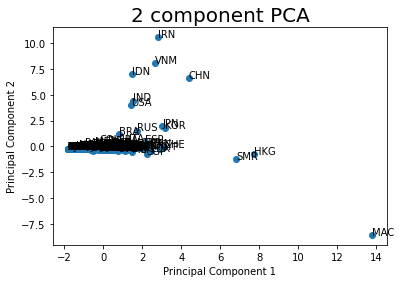

In [0]:
fig = plt.figure(figsize = (25,15))
fig, ax = plt.subplots()
ax.scatter(finalDf['principal component 1'], finalDf['principal component 2'])
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('2 component PCA', fontsize = 20)

for i, txt in enumerate(finalDf['ISO-3 code']):
    ax.annotate(txt, (finalDf['principal component 1'][i], finalDf['principal component 2'][i]));

<Figure size 1800x1080 with 0 Axes>

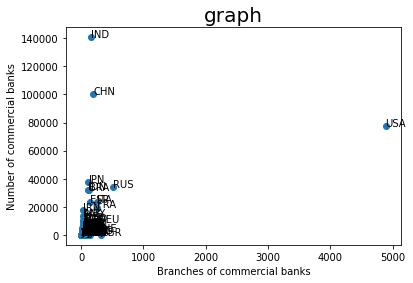

In [0]:
fig = plt.figure(figsize = (25,15))
fig, ax = plt.subplots()
ax.scatter(imf_2017['Number of commercial banks'], imf_2017['Branches of commercial banks'])
ax.set_xlabel('Branches of commercial banks', fontsize = 10)
ax.set_ylabel('Number of commercial banks', fontsize = 10)
ax.set_title('graph', fontsize = 20)

for i, txt in enumerate(imf_2017['ISO-3 code']):
    ax.annotate(txt, (imf_2017['Number of commercial banks'][i], imf_2017['Branches of commercial banks'][i]));

In [0]:
#rank country and calculate the financial and borrow average
worldb.columns;

In [0]:
wb_fin=worldb.loc[:,[ 'Year','ios','Country','Financial institution account (% age 15+) ',
       'Financial institution account,male(% age 15+) ',
       'Financial institution account, in labor force(% age 15+) ',
       'Financial institution account, out of labor force (% age 15+) ',
       'Financial institution account,female(% age 15+) ',
       'Financial institution account,young adults(% age 15-24) ',
       'Financial institution account, older adults(% age 25+) ',
       'Financial institution account, primary education or less(% age 15+) ',
       'Financial institution account, seconday education or more(% age 15+) ',
       'Financial institution account,income,poorest 40% (% age 15+) ',
       'Financial institution account,income,richest 60% (% age 15+) ',
       'Financial institution account, rural(% age 15+) ',]]

In [0]:
wb_acct=worldb.loc[:,['Year', 'ios', 'Country', 'Region', 'status',
       'Account, young adults (% ages 15-24)',
       'Account, older adults (% ages 25+)',
       'Account, primary education or less (% ages 15+) ',
       'Account, secondary education or more (% ages 15+) ',
       'Account, income, poorest 40% (% ages 15+)',
       'Account, income, richest 60% (% ages 15+) ',
       'Account, rural (% age 15+) ']]
wb_cred=worldb.loc[:,['Year', 'ios','Country','Credit card ownership (% age 15+) ',
       'Credit card ownership, male (% age 15+) ',
       'Credit card ownership, in labor force  (% age 15+) ',
       'Credit card ownership, out of labor force  (% age 15+) ',
       'Credit card ownership, female  (% age 15+) ',
       'Credit card ownership, young adults  (% age 15-24) ',
       'Credit card ownership, older adults  (% age 25+) ',
       'Credit card ownership, primary education or less  (% age 15+) ',
       'Credit card ownership, secondary education or more  (% age 15+) ',
       'Credit card ownership, income, poorest 40%  (% age 15+) ',
       'Credit card ownership, income, richest 60% (% age 15+) ',
       'Credit card ownership, rural  (% age 15+) ']]
wb_deb=worldb.loc[:,['Year', 'ios','Country', 'Debit card ownership (% age 15+) ',
       'Debit card ownership, male  (% age 15+) ',
       'Debit card ownership, in labor force (% age 15+) ',
       'Debit card ownership, out of labor force (% age 15+) ',
       'Debit card ownership, female (% age 15+) ',
       'Debit card ownership, young adults (% age 15-24) ',
       'Debit card ownership, older adults (% age 25+) ',
       'Debit card ownership, primary education or less (% age 15+) ',
       'Debit card ownership, secondary education or more (% age 15+) ',
       'Debit card ownership, income, poorest 40% (% age 15+) ',
       'Debit card ownership, income, richest 60% (% age 15+) ',
       'Debit card ownership, rural (% age 15+) ']]
wb_sav=worldb.loc[:,['Year', 'ios','Country', 'Saved at a financial institution (% age 15+) ',
       'Saved at a financial institution, male (% age 15+) ',
       'Saved at a financial institution, in labor force (% age 15+) ',
       'Saved at a financial institution , out of labor force (% age 15+) ',
       'Saved at a financial institution, female (% age 15+) ',
       'Saved at a financial institution, young adults (% age 15-24) ',
       'Saved at a financial institution, older adults (% age 25+) ',
       'Saved at a financial institution, primary education or less(% age 15+) ',
       'Saved at a financial institution, secondary education or more (% age 15+) ',
       'Saved at a financial institution, income, poorest 40% (% age 15+) ',
       'Saved at a financial institution, income, richest 60%  (% age 15+) ',
       'Saved at a financial institution, rural  (% age 15+) ']]

In [0]:
wb_borr=worldb.loc[:,['Year','ios','Country','Borrowed from a financial institution (% age 15+) ',
       'Borrowed from a financial institution, male (% age 15+) ',
       'Borrowed from a financial institution, in labor force (% age 15+) ',
       'Borrowed from a financial institution, out of labor force (% age 15+) ',
       'Borrowed from a financial institution, female (% age 15+) ',
       'Borrowed from a financial institution, young adults  (% age 15-24) ',
       'Borrowed from a financial institution, older adults  (% age 25+) ',
       'Borrowed from a financial institution, primary education or less (% age 15+) ',
       'Borrowed from a financial institution, secondary education or more (% age 15+) ',
       'Borrowed from a financial institution, income, poorest 40% (% age 15+) ',
       'Borrowed from a financial institution, income, richest 60% (% age 15+) ',
       'Borrowed from a financial institution, rural (% age 15+) ']]

In [0]:
#calculate the average
wb_fin['av_fin']=wb_fin.iloc[:,3:].mean(axis=1).round(2)
wb_borr['av_borr']=wb_borr.iloc[:,3:].mean(axis=1).round(2)
wb_cred['av_cred']=wb_cred.iloc[:,3:].mean(axis=1).round(2)
wb_deb['av_deb']=wb_deb.iloc[:,3:].mean(axis=1).round(2)
wb_acct['av_acct']=wb_acct.iloc[:,3:].mean(axis=1).round(2)
wb_sav['av_sav']=wb_sav.iloc[:,3:].mean(axis=1).round(2)

In [0]:
#sort value
wb_borr_sort=wb_borr.sort_values(by='av_borr',ascending=False)
wb_fin_sort=wb_fin.sort_values(by='av_fin',ascending=False)
wb_cred_sort=wb_cred.sort_values(by='av_cred',ascending=False)
wb_deb_sort=wb_deb.sort_values(by='av_deb',ascending=False)
wb_acct_sort=wb_acct.sort_values(by='av_acct',ascending=False)
wb_sav_sort=wb_sav.sort_values(by='av_sav',ascending=False)


In [0]:
rank_borr_2011=wb_borr_sort[wb_borr_sort['Year']==2011]
rank_fin_2011=wb_fin_sort[wb_fin_sort['Year']==2011]
rank_cred_2011=wb_cred_sort[wb_cred_sort['Year']==2011]
rank_deb_2011=wb_deb_sort[wb_deb_sort['Year']==2011]
rank_acct_2011=wb_acct_sort[wb_acct_sort['Year']==2011]
rank_sav_2011=wb_sav_sort[wb_sav_sort['Year']==2011]

In [0]:
dim_2011=pd.read_csv('dim_2011_FI.csv')
dim_2011=dim_2011.iloc[:,:-2]
dim_2011=dim_2011.sort_values(by='rank',ascending=False)
dim_2011=dim_2011.rename(columns={"Composite_Index": 'Comp_ind'})
dim_2011.tail()

,Country,Dimension_1,Dimension_2,Comp_ind,rank
14,Dominican Republic,0.210172,0.349337,0.268521,5
17,Mauritius,1.000000,0.086771,0.307682,4
24,Brunei Darussalam,0.161572,0.927689,0.375285,3
22,Thailand,0.242880,0.694637,0.403129,2
16,Maldives,0.863824,0.353462,0.561434,1


In [0]:
#dim_2011=dim_index[dim_index['Year']==2011]
data_2011=dim_2011.copy()
rank_borr_data_11=rank_borr_2011.iloc[:,[2,-1]]
rank_acct_data_11=rank_acct_2011.iloc[:,[2,-1]]
rank_deb_data_11=rank_deb_2011.iloc[:,[2,-1]]
rank_cred_data_11=rank_cred_2011.iloc[:,[2,-1]]
rank_sav_data_11=rank_sav_2011.iloc[:,[2,-1]]
rank_fin_data_11=rank_fin_2011.iloc[:,[2,-1]]

In [0]:
data_dim_borr_11=data_2011.merge(rank_borr_data_11,how='inner',
left_on='Country',right_on='Country')
data_dim_acct_11=data_2011.merge(rank_acct_data_11,how='inner',
left_on='Country',right_on='Country')
data_dim_deb_11=data_2011.merge(rank_deb_data_11,how='inner',
left_on='Country',right_on='Country')
data_dim_sav_11=data_2011.merge(rank_sav_data_11,how='inner',
left_on='Country',right_on='Country')
data_dim_cred_11=data_2011.merge(rank_cred_data_11,how='inner',
left_on='Country',right_on='Country')
data_dim_fin_11=data_2011.merge(rank_fin_data_11,how='inner',
                                 left_on='Country',right_on='Country')

In [0]:
print('correlated with borrow' ,data_dim_borr_11[['Comp_ind','av_borr']].corr())
print('--------------------------------------------------------------------------')
print('correlated with financial' ,data_dim_fin_11[['Comp_ind','av_fin']].corr())
print('--------------------------------------------------------------------------')
print('correlated with account' ,data_dim_acct_11[['Comp_ind','av_acct']].corr())
print('--------------------------------------------------------------------------')
print('correlated with saving' ,data_dim_sav_11[['Comp_ind','av_sav']].corr())
print('--------------------------------------------------------------------------')
print('correlated with credit' ,data_dim_cred_11[['Comp_ind','av_cred']].corr())
print('--------------------------------------------------------------------------')
print('correlated with debit' ,data_dim_deb_11[['Comp_ind','av_deb']].corr())

correlated with borrow           Comp_ind   av_borr
Comp_ind  1.000000  0.816177
av_borr   0.816177  1.000000
--------------------------------------------------------------------------
correlated with financial           Comp_ind    av_fin
Comp_ind  1.000000  0.778365
av_fin    0.778365  1.000000
--------------------------------------------------------------------------
correlated with account           Comp_ind   av_acct
Comp_ind  1.000000  0.774655
av_acct   0.774655  1.000000
--------------------------------------------------------------------------
correlated with saving           Comp_ind    av_sav
Comp_ind  1.000000  0.827339
av_sav    0.827339  1.000000
--------------------------------------------------------------------------
correlated with credit           Comp_ind  av_cred
Comp_ind   1.00000  0.48324
av_cred    0.48324  1.00000
--------------------------------------------------------------------------
correlated with debit           Comp_ind    av_deb
Comp_ind  1.000000  0.6

<Figure size 1800x1080 with 0 Axes>

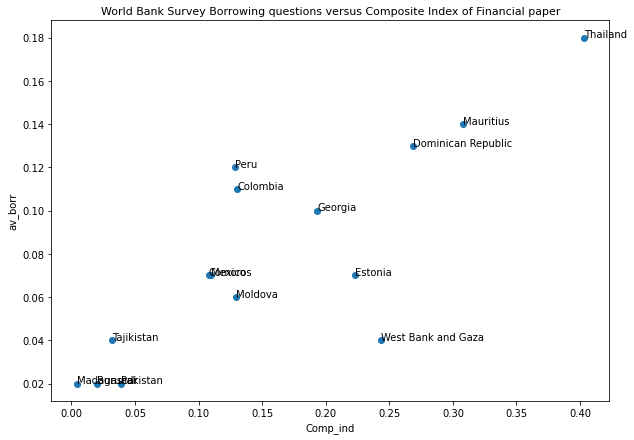

In [0]:
fig = plt.figure(figsize = (25,15))
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(data_dim_borr_11['Comp_ind'], 
           data_dim_borr_11['av_borr'])
ax.set_xlabel('Comp_ind', fontsize = 10)
ax.set_ylabel('av_borr', fontsize = 10)
ax.set_title('World Bank Survey Borrowing questions versus Composite Index of Financial paper', 
             fontsize = 11);

for i, txt in enumerate(data_dim_borr_11['Country']):
    ax.annotate(txt, (data_dim_borr_11['Comp_ind'][i],
                      data_dim_borr_11['av_borr'][i]));

<Figure size 1800x1080 with 0 Axes>

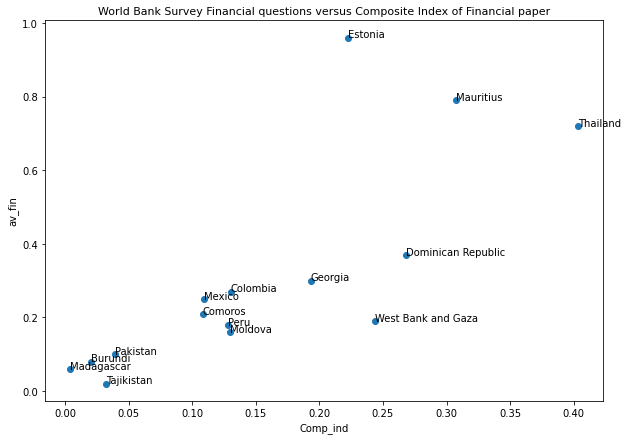

In [0]:
fig = plt.figure(figsize = (25,15))
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(data_dim_fin_11['Comp_ind'], 
           data_dim_fin_11['av_fin'])
ax.set_xlabel('Comp_ind', fontsize = 10)
ax.set_ylabel('av_fin', fontsize = 10)
ax.set_title('World Bank Survey Financial questions versus Composite Index of Financial paper', 
             fontsize = 11);

for i, txt in enumerate(data_dim_fin_11['Country']):
    ax.annotate(txt, (data_dim_fin_11['Comp_ind'][i],
                      data_dim_fin_11['av_fin'][i]));

<Figure size 1800x1080 with 0 Axes>

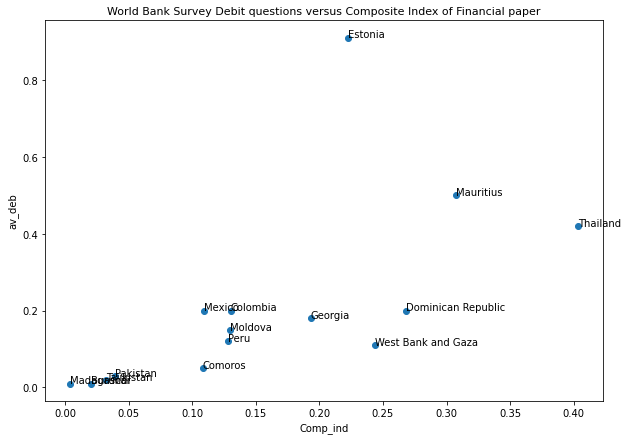

In [0]:
fig = plt.figure(figsize = (25,15))
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(data_dim_deb_11['Comp_ind'], 
           data_dim_deb_11['av_deb'])
ax.set_xlabel('Comp_ind', fontsize = 10)
ax.set_ylabel('av_deb', fontsize = 10)
ax.set_title('World Bank Survey Debit questions versus Composite Index of Financial paper', 
             fontsize = 11);

for i, txt in enumerate(data_dim_deb_11['Country']):
    ax.annotate(txt, (data_dim_deb_11['Comp_ind'][i],
                      data_dim_deb_11['av_deb'][i]));

<Figure size 1800x1080 with 0 Axes>

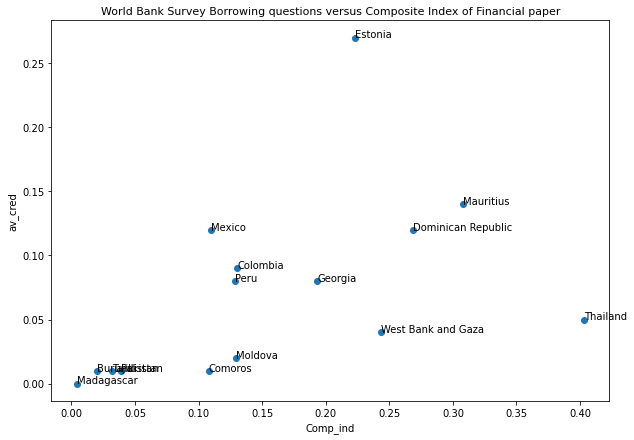

In [0]:
fig = plt.figure(figsize = (25,15))
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(data_dim_cred_11['Comp_ind'], 
           data_dim_cred_11['av_cred'])
ax.set_xlabel('Comp_ind', fontsize = 10)
ax.set_ylabel('av_cred', fontsize = 10)
ax.set_title('World Bank Survey Borrowing questions versus Composite Index of Financial paper', 
             fontsize = 11);

for i, txt in enumerate(data_dim_cred_11['Country']):
    ax.annotate(txt, (data_dim_cred_11['Comp_ind'][i],
                      data_dim_cred_11['av_cred'][i]));

<Figure size 1800x1080 with 0 Axes>

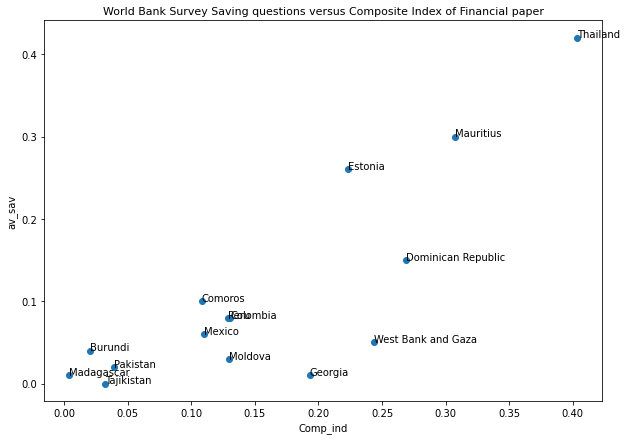

In [0]:
fig = plt.figure(figsize = (25,15))
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(data_dim_sav_11['Comp_ind'], 
           data_dim_sav_11['av_sav'])
ax.set_xlabel('Comp_ind', fontsize = 10)
ax.set_ylabel('av_sav', fontsize = 10)
ax.set_title('World Bank Survey Saving questions versus Composite Index of Financial paper', 
             fontsize = 11);

for i, txt in enumerate(data_dim_sav_11['Country']):
    ax.annotate(txt, (data_dim_sav_11['Comp_ind'][i],
                      data_dim_sav_11['av_sav'][i]));

<Figure size 1800x1080 with 0 Axes>

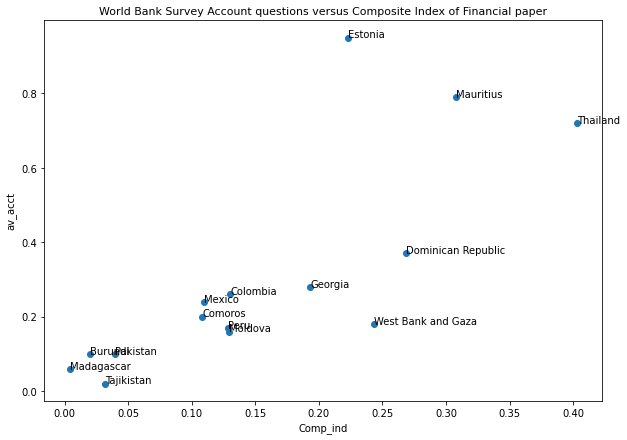

In [0]:
fig = plt.figure(figsize = (25,15))
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(data_dim_acct_11['Comp_ind'], 
           data_dim_acct_11['av_acct'])
ax.set_xlabel('Comp_ind', fontsize = 10)
ax.set_ylabel('av_acct', fontsize = 10)
ax.set_title('World Bank Survey Account questions versus Composite Index of Financial paper', 
             fontsize = 11);

for i, txt in enumerate(data_dim_acct_11['Country']):
    ax.annotate(txt, (data_dim_acct_11['Comp_ind'][i],
                      data_dim_acct_11['av_acct'][i]));

<Figure size 1800x1080 with 0 Axes>

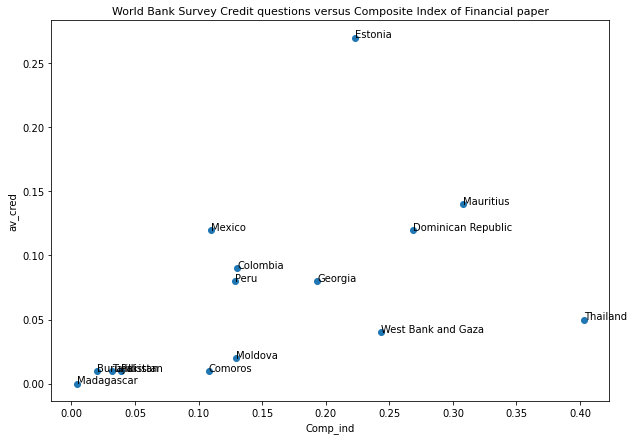

In [0]:
fig = plt.figure(figsize = (25,15))
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(data_dim_cred_11['Comp_ind'], 
           data_dim_cred_11['av_cred'])
ax.set_xlabel('Comp_ind', fontsize = 10)
ax.set_ylabel('av_cred', fontsize = 10)
ax.set_title('World Bank Survey Credit questions versus Composite Index of Financial paper', 
             fontsize = 11);

for i, txt in enumerate(data_dim_cred_11['Country']):
    ax.annotate(txt, (data_dim_cred_11['Comp_ind'][i],
                      data_dim_cred_11['av_cred'][i]));